## Multivariate LSTM Forecast model

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1        0.0        0.0        0.0        0.0        0.0        0.0   
2        0.0        0.0        0.0        0.0        0.0        0.0   
3        0.0        0.0        0.0        0.0        0.0        0.0   
4        0.0        0.0        0.0        0.0        0.0        0.0   
5        0.0        0.0        0.0        0.0        0.0        0.0   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  ...  var32(t-1)  var33(t-1)  \
1        0.0        0.0        0.0         0.0  ...         0.0         0.0   
2        0.0        0.0        0.0         0.0  ...         0.0         0.0   
3        0.0        0.0        0.0         0.0  ...         0.0         0.0   
4        0.0        0.0        0.0         0.0  ...         0.0         0.0   
5        0.0        0.0        1.0         1.0  ...         0.0         0.0   

   var34(t-1)  var35(t-1)  var36(t-1)  var37(t-1)  var38(t-1)  var39(t-1)  \
1         0.0        

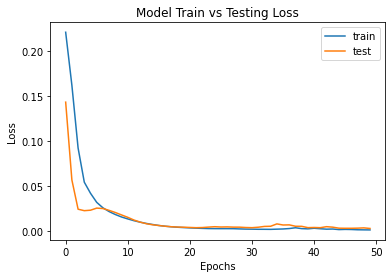

Test RMSE: 101.622
Model saved to disk


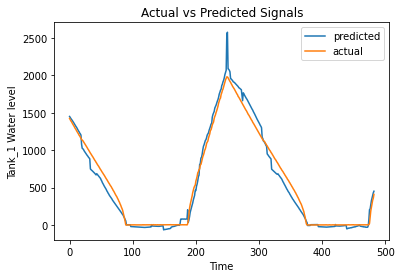

In [1]:
from math import sqrt
from numpy import array
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# convert series to supervised learning
def series_to_supervised2(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


# load dataset
#dataset = read_csv('pollution.csv', header=0, index_col=0)
#dataset = read_csv('phy_cps.csv', header=0, index_col=0)
dataset = read_csv('phy_att_test_processed.csv', header=0, index_col=0)
values = dataset.to_numpy()
# integer encode direction
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised2(scaled, 1, 1)

# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
#reframed.drop(reframed.columns[[0,1,2,3,4,5]], axis=1, inplace=True)
#reframed.drop(reframed.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37]], axis=1, inplace=True)
#reframed.drop(reframed.columns[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39]], axis=1, inplace=True)
reframed.drop(reframed.columns[[41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79]], axis=1, inplace=True)
print(reframed.head())
 
# split into train and test sets
values = reframed.values
#n_train_hours = 365 * 24
#n_train_hours = 484
n_train_hours = 1936
# Not 1936
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
# design network
model = Sequential()
#model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(20, activation='relu',return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(10, activation='relu', return_sequences=True))
model.add(LSTM(5, activation='relu'))
model.add(Dense(1))
#model.compile(loss='mae', optimizer='adam')
model.compile(loss='mse', optimizer='adam')
# fit network
#history = model.fit(train_X, train_y, epochs=70, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)
history = model.fit(train_X, train_y, epochs=50, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')
pyplot.title('Model Train vs Testing Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

'''
pyplot.plot(inv_yhat, label='predicted')
pyplot.plot(test_y, label='actual')
pyplot.legend()
pyplot.show()
'''

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

# Save the model to disk
model.save('lstm_model.h5')
print('Model saved to disk')

pyplot.xlabel('Time')
pyplot.ylabel('Tank_1 Water level')
pyplot.title('Actual vs Predicted Signals')
pyplot.plot(inv_yhat, label='predicted')
pyplot.plot(inv_y, label='actual')
pyplot.legend()
# pyplot.legend(['train','test'], loc='upper left')
pyplot.show()


## Load the saved model

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.892424   0.548454   0.653787   0.020599   0.000000   0.156182   
2   0.908081   0.543299   0.656878   0.017790   0.000000   0.156182   
3   0.918182   0.535052   0.665379   0.018727   0.001214   0.138829   
4   0.934343   0.529897   0.667697   0.019663   0.001214   0.121475   
5   0.953030   0.522165   0.677743   0.019663   0.001214   0.121475   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  ...  var32(t-1)  var33(t-1)  \
1        1.0   0.586957        0.0         1.0  ...         0.0         0.0   
2        1.0   0.586957        0.0         1.0  ...         0.0         0.0   
3        1.0   0.602767        0.0         1.0  ...         0.0         0.0   
4        1.0   0.618577        0.0         1.0  ...         0.0         0.0   
5        1.0   0.634387        0.0         1.0  ...         0.0         0.0   

   var34(t-1)  var35(t-1)  var36(t-1)  var37(t-1)  var38(t-1)  var39(t-1)  \
1         0.0        

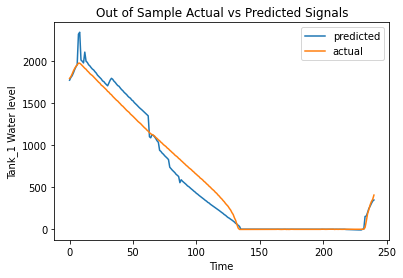

In [38]:
from pandas import read_csv
from keras.models import load_model

model = load_model('lstm_model.h5')

out_dataset = read_csv('phy_cps_out-of-sample.csv', header=0, index_col=0)
t_values = out_dataset.to_numpy()

t_values = out_dataset.values

t_values = t_values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(t_values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
#reframed.drop(reframed.columns[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39]], axis=1, inplace=True)
reframed.drop(reframed.columns[[41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79]], axis=1, inplace=True)
print(reframed.head())
 
# split into train and test sets
t_values = reframed.values

test = t_values
# split into input and outputs
#train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
#print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# plot history
'''
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
'''
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

model.summary()

pyplot.xlabel('Time')
pyplot.ylabel('Tank_1 Water level')
pyplot.title('Out of Sample Actual vs Predicted Signals')
pyplot.plot(inv_yhat, label='predicted')
pyplot.plot(inv_y, label='actual')
pyplot.legend()
pyplot.show()

### Out of sample testing

   var1(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   var5(t)   var6(t)  \
1   0.892424  0.908081  0.543299  0.656878  0.017790  0.000000  0.156182   
2   0.908081  0.918182  0.535052  0.665379  0.018727  0.001214  0.138829   
3   0.918182  0.934343  0.529897  0.667697  0.019663  0.001214  0.121475   
4   0.934343  0.953030  0.522165  0.677743  0.019663  0.001214  0.121475   
5   0.953030  0.967677  0.515464  0.680835  0.016854  0.001214  0.086768   

   var7(t)   var8(t)  var9(t)  ...  var31(t)  var32(t)  var33(t)  var34(t)  \
1      1.0  0.586957      0.0  ...       0.0       0.0       0.0       0.0   
2      1.0  0.602767      0.0  ...       0.0       0.0       0.0       0.0   
3      1.0  0.618577      0.0  ...       0.0       0.0       0.0       0.0   
4      1.0  0.634387      0.0  ...       0.0       0.0       0.0       0.0   
5      1.0  0.650198      0.0  ...       0.0       0.0       0.0       0.0   

   var35(t)  var36(t)  var37(t)  var38(t)  var39(t)  var40(t)  
1       1.

Epoch 84/100
61/61 - 0s - loss: 0.0086 - val_loss: 0.0512 - 249ms/epoch - 4ms/step
Epoch 85/100
61/61 - 0s - loss: 0.0095 - val_loss: 0.0577 - 219ms/epoch - 4ms/step
Epoch 86/100
61/61 - 0s - loss: 0.0085 - val_loss: 0.0393 - 246ms/epoch - 4ms/step
Epoch 87/100
61/61 - 0s - loss: 0.0101 - val_loss: 0.0336 - 284ms/epoch - 5ms/step
Epoch 88/100
61/61 - 0s - loss: 0.0091 - val_loss: 0.0422 - 253ms/epoch - 4ms/step
Epoch 89/100
61/61 - 0s - loss: 0.0089 - val_loss: 0.0512 - 187ms/epoch - 3ms/step
Epoch 90/100
61/61 - 0s - loss: 0.0078 - val_loss: 0.0449 - 183ms/epoch - 3ms/step
Epoch 91/100
61/61 - 0s - loss: 0.0076 - val_loss: 0.0368 - 168ms/epoch - 3ms/step
Epoch 92/100
61/61 - 0s - loss: 0.0076 - val_loss: 0.0393 - 183ms/epoch - 3ms/step
Epoch 93/100
61/61 - 0s - loss: 0.0073 - val_loss: 0.0460 - 186ms/epoch - 3ms/step
Epoch 94/100
61/61 - 0s - loss: 0.0071 - val_loss: 0.0454 - 180ms/epoch - 3ms/step
Epoch 95/100
61/61 - 0s - loss: 0.0069 - val_loss: 0.0395 - 183ms/epoch - 3ms/step
Epoc

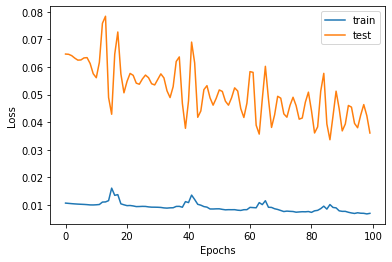

Test RMSE: 1592.419


In [13]:
#dataset = out_dataset
out_dataset = read_csv("phy_cps_out-of-sample.csv", header=0, index_col=0)
t_values = out_dataset.to_numpy()

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
#dataset = read_csv('pollution.csv', header=0, index_col=0)
#dataset = read_csv('phy_cps.csv', header=0, index_col=0)
t_values = out_dataset.values
# integer encode direction
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
t_values = t_values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(t_values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed.drop(reframed.columns[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39]], axis=1, inplace=True)
print(reframed.head())
 
# split into train and test sets
t_values = reframed.values

test = t_values
# split into input and outputs
#train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
#print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# # design network
# model = Sequential()
# model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(Dense(1))
# model.compile(loss='mae', optimizer='adam')

# fit network
#history = model.fit(train_X, train_y, epochs=70, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)
history = model.fit(train_X, train_y, epochs=100, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)